# Submission Dicoding ML

**Data Diri**

*   Nama   : Adhitya Bagasmiwa Permana
*   Alamat : Kabupaten Bantul, Daerah Istimewa Yogyakarta
*   Email  : adhityabagas98@gmail.com



In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# download dataset
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rps.zip

--2020-10-10 11:50:33--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 307.92M  5.92MB/s    in 41s     

2020-10-10 11:51:15 (7.57 MB/s) - ‘/tmp/rps.zip’ saved [322873683/322873683]



In [ ]:
# ekstraksi pada file zip
import zipfile,os
local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

**Import Library**

In [ ]:
# library plot realtime
!pip install livelossplot

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from livelossplot import PlotLossesKerasTF

print(tf.__version__)

2.3.0


**Prepocessing Dataset dengan Split 60% - 40%**

In [ ]:
# mengatur lokasi dataset
base_dir = '/tmp/rockpaperscissors/rps-cv-images'

# mengatur dataset
img_size = 150
bs = 64

In [ ]:
# membuat datagen untuk augmentasi
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.4  # mengatur val split 40%
    )

In [ ]:
# membuat data generator train
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=bs,
    class_mode='categorical',
    subset='training',  # mengatur sebagai train data
    shuffle=True
    ) 

# membuat data generator val
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=bs,
    class_mode='categorical',
    subset='validation',  # mengatur sebagai val data
    shuffle=False
    ) 

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


**Arsitektur CNN**

In [ ]:
model = Sequential()

# Block - 1
model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(2, 2, padding='same'))
model.add(Dropout(0.25))

# Block - 2
model.add(Conv2D(32, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2, padding='same'))
model.add(Dropout(0.25))

# Block - 3
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2, padding='same'))
model.add(Dropout(0.25))

# Block - 4
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2, padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())  # flattening

model.add(Dense(512, activation='relu'))  # hidden layer - 1
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu')) # hidden layer - 2
model.add(Dropout(0.25))

model.add(Dense(3, activation='softmax')) # classifier

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 64)        1

**Optimizer**

In [ ]:
adam = Adam(lr=0.001)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

**Callback**

In [ ]:
filepath_acc='/content/drive/My Drive/Colab Notebooks/output-models/submission-dicoding/best_acc_weights.hdf5'
filepath_loss='/content/drive/My Drive/Colab Notebooks/output-models/submission-dicoding/best_loss_weights.hdf5'

# model checkpoint untuk menyimpan best acc/loss model
checkpoint_loss = ModelCheckpoint(filepath_loss, verbose=1, monitor='val_loss', save_best_only=True, mode='min')
checkpoint_acc = ModelCheckpoint(filepath_acc, verbose=1, monitor='val_accuracy', save_best_only=True, mode='max')

# early stop train apabila val loss bertambah
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

# mengurangi lr apabila val acc tidak bertambah
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=3, min_delta=1e-4, verbose=1)

# list callback
callbacks_list = [PlotLossesKerasTF(), checkpoint_loss, checkpoint_acc, early_stopping, lr_reduce]

**Train Model**

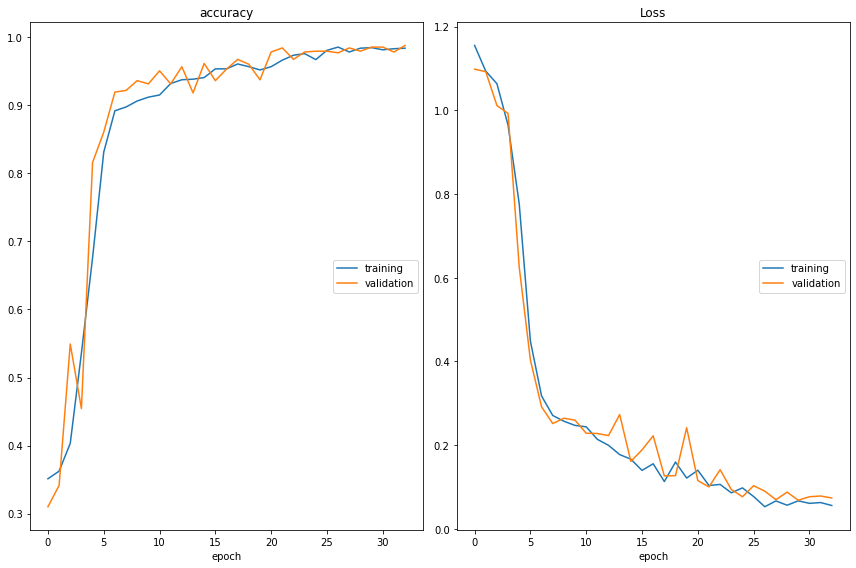

accuracy
	training         	 (min:    0.351, max:    0.986, cur:    0.984)
	validation       	 (min:    0.310, max:    0.988, cur:    0.988)
Loss
	training         	 (min:    0.053, max:    1.155, cur:    0.056)
	validation       	 (min:    0.068, max:    1.099, cur:    0.074)

Epoch 00033: val_loss did not improve from 0.06840

Epoch 00033: val_accuracy improved from 0.98558 to 0.98798, saving model to /content/drive/My Drive/Colab Notebooks/output-models/submission-dicoding/best_acc_weights.hdf5
Restoring model weights from the end of the best epoch.
20/20 - 14s - loss: 0.0558 - accuracy: 0.9840 - val_loss: 0.0738 - val_accuracy: 0.9880
Epoch 00033: early stopping
CPU times: user 8min 12s, sys: 17.3 s, total: 8min 30s
Wall time: 8min 5s


In [ ]:
%%time

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = val_generator.n//val_generator.batch_size

history = model.fit(
        train_generator, 
        steps_per_epoch=steps_per_epoch,
        epochs=50, 
        validation_data=val_generator,
        validation_steps=validation_steps, 
        verbose=2,
        callbacks=callbacks_list
    )

**Evaluasi Model setelah Training**

In [ ]:
eval_val = model.evaluate(val_generator, steps=validation_steps) 
print("\nVal Loss " + str(eval_val[0]))
print("Val Acc: " + str(eval_val[1]))

13/13 [==============================] - 5s 358ms/step - loss: 0.0813 - accuracy: 0.9796

Val Loss 0.08131088316440582
Val Acc: 0.979567289352417


**Predict**

Saving kertas.jpg to kertas.jpg
kertas.jpg
[0]
Predict : Paper


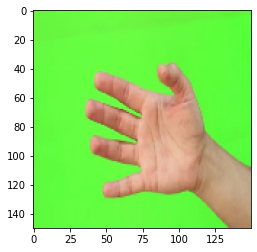

In [ ]:
from tensorflow.keras.models import load_model

import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

model = load_model(filepath_acc)  # load model
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=16)
  predIdxs = np.argmax(classes, axis=1)
  
  print(fn)
  print(predIdxs)
  if classes[0, 0] != 0:
    print('Predict : Paper')
  elif classes[0, 1] != 0:
    print('Predict : Rock')
  else:
    print('Predict : Scissors')